In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_text as text          # needed for loading bert from hub
from official.nlp import optimization   # to create AdamW optimizer
from matplotlib import pyplot as plt
from collections import defaultdict

tf.get_logger().setLevel('ERROR')
tf.__version__, tf.config.list_physical_devices('GPU')

('2.10.1', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [2]:
from utils.preprocessing import preprocess

raw_ds = preprocess('tfcm')

Total number of news: 30339
Maximum number of news for each group in training set: 64
Minimum number of news for each group in training set: 3
Maximum number of news for each group in test set: 26
Minimum number of news for each group in test set: 3
Maximum number of times a news appears in training set: 22
Minimum number of times a news appears in training set: 0
Maximum number of times a news appears in test set: 11
Minimum number of times a news appears in test set: 0


In [3]:
valueRange = set(raw_ds['score'].values())
len(raw_ds['score']), len(valueRange)

(24160, 52)

In [9]:
countLine = 0
countID = defaultdict(int)
flag = False
countInLine = 0
flagIn = False
for line in raw_ds['test']:
    for ID in line:
        if ID not in raw_ds['score']:
            countID[ID] += 1
            flag = True
        else:
            flagIn = True
    if flag:
        countLine += 1
        flag = False
    if flagIn:
        countInLine += 1
        flag1 = False
countLine, countInLine, len(raw_ds['test']), len(countID)

(2460, 2590, 3000, 6179)

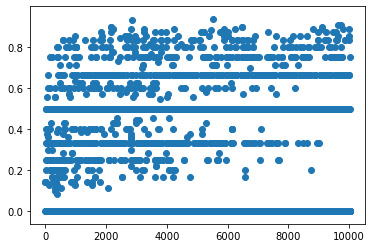

In [5]:
plt.scatter(range(len(raw_ds['score'])), raw_ds['score'].values())

In [19]:
np.array(raw_ds['train_reg'])[:,0]

array(['5187439', '176694', '175203', ..., '5539285', '179996', '9321204'],
      dtype='<U32')

In [3]:
train_data = np.vectorize(id2text:= lambda x: raw_ds['news'][x])(np.array(raw_ds['train_reg'])[:,0])
train_label = np.array(raw_ds['train_reg'])[:,1].astype(np.float32)
valid_data = np.vectorize(id2text)(np.array(raw_ds['valid_reg'])[:,0])
valid_label = np.array(raw_ds['valid_reg'])[:,1].astype(np.float32)
valid_label

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_label))
len(train_ds), len(valid_ds)

(21744, 2416)

In [5]:
# tf.compat.v1.disable_eager_execution()
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 512
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
num_train, num_valid = len(train_ds), len(valid_ds)
num_train, num_valid

(680, 76)

In [9]:
for x, y in train_ds.take(1):
    print(x[0].shape, x[1].shape, y.shape)
y

(32,) (32,) (32,)


<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. ,
       1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 0. , 1. ,
       1. , 0. , 1. , 1. , 0. , 1. ], dtype=float32)>

In [6]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.metrics.MeanAbsoluteError()
epochs = 3
num_train_steps = num_train * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
callbacks = tf.keras.callbacks.TensorBoard(log_dir='logs')
title_units = 32
content_units = 128
final_units = 16

In [7]:
from model import tfcm

regressioner = tfcm.build_regression_model(title_units, content_units, final_units, fine_tune=False)

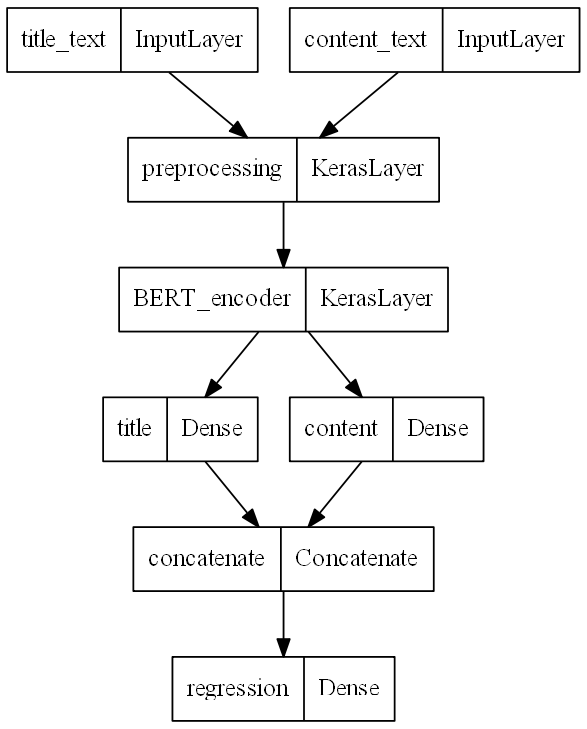

In [12]:
from utils.visualization import plot_structure, plot_history

plot_structure(regressioner, 'bert_regressioner.png')

In [8]:
regressioner.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = regressioner.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[callbacks])

Epoch 1/3
680/680 [==============================] - 682s 984ms/step - loss: 0.2243 - mean_absolute_error: 0.4343 - val_loss: 0.2130 - val_mean_absolute_error: 0.4151
Epoch 2/3
 17/680 [..............................] - ETA: 9:51 - loss: 0.2214 - mean_absolute_error: 0.4363

Exception ignored in: <function UniquePtr.__del__ at 0x0000020F2A71B1F0>
Traceback (most recent call last):
  File "D:\Anaconda\envs\py38\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
KeyboardInterrupt: 

KeyboardInterrupt



In [8]:
test_data = np.vectorize(id2text)(np.array(list(raw_ds['test_reg'])))
test_label = regressioner.predict(test_data)
test_label

194/194 [==============================] - 163s 822ms/step


array([[0.30970308],
       [0.40913782],
       [0.46554124],
       ...,
       [0.41435316],
       [0.48215252],
       [0.24554573]], dtype=float32)

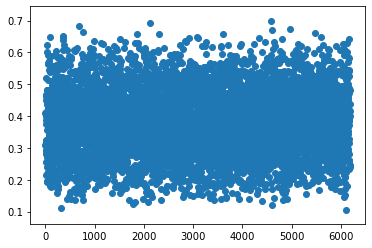

In [9]:
plt.scatter(range(len(test_label)), test_label)
plt.show()

In [10]:
scores = dict(raw_ds['score'], **dict(zip(raw_ds['test_reg'], test_label.flatten())))
scores

{'44374': 0.0,
 '44416': 0.14285714285714285,
 '2913537': 0.14285714285714285,
 '2913541': 0.14285714285714285,
 '3074529': 1.0,
 '49422': 1.0,
 '49429': 0.8,
 '7785735': 1.0,
 '132569': 1.0,
 '132604': 1.0,
 '132610': 1.0,
 '46844': 1.0,
 '2990192': 0.5,
 '2991404': 1.0,
 '2991427': 1.0,
 '2991450': 1.0,
 '2992028': 0.6666666666666666,
 '2993613': 0.6,
 '2957871': 1.0,
 '2958394': 1.0,
 '45884': 1.0,
 '2959890': 1.0,
 '46062': 1.0,
 '165623': 1.0,
 '165624': 1.0,
 '165671': 1.0,
 '8744403': 1.0,
 '165686': 1.0,
 '165699': 1.0,
 '165772': 1.0,
 '2745143': 1.0,
 '37582': 1.0,
 '2745231': 1.0,
 '2745306': 0.5,
 '151530': 0.4,
 '151551': 0.0,
 '151624': 0.0,
 '31314': 1.0,
 '31333': 1.0,
 '31341': 1.0,
 '31358': 1.0,
 '31368': 1.0,
 '140549': 1.0,
 '140567': 1.0,
 '140563': 1.0,
 '140624': 1.0,
 '3411064': 0.0,
 '59866': 0.0,
 '59921': 0.5,
 '3414600': 0.0,
 '84699': 0.0,
 '4871183': 0.0,
 '84702': 0.0,
 '5353284': 0.8333333333333334,
 '94600': 1.0,
 '5355512': 0.75,
 '3531193': 1.0,
 '64

In [11]:
test_data = [[scores[ID] for ID in line] for line in raw_ds['test']]
test_data

[[1.0, 1.0, 0.6666666666666666, 0.6666666666666666],
 [1.0, 1.0, 0.5, 0.24005185, 1.0],
 [0.57310146, 0.53623784, 0.5733502],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [0.31239367, 1.0, 1.0],
 [1.0, 0.25013155, 0.875],
 [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.7142857142857143, 1.0],
 [0.0, 0.0, 0.4],
 [1.0, 1.0, 1.0, 1.0],
 [0.3275017, 0.9375, 0.8823529411764706],
 [0.38726196,
  0.33928102,
  0.3668397,
  0.37161782,
  0.352773,
  0.8333333333333334,
  0.8],
 [0.4864599, 0.23516937, 1.0],
 [0.5555439, 0.30815434, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 0.21308772, 1.0, 1.0, 1.0],
 [0.42883614, 0.541218, 0.3457401],
 [0.43259847, 0.5500166, 0.4526347],
 [0.0, 0.33354464, 0.3410396, 0.4247507, 0.3653216, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [0.40324268, 0.3554246, 0.4276515, 0.0, 0.5],
 [0.41831592, 0.6079588, 1.0],
 [0.5292235, 0.3078025, 1.0, 1.0, 1.0, 0.28957325],
 [1.0, 0.30999553, 1.0, 1.0],
 [1.0, 0.38785383, 1.0, 0.5020118, 1.0],
 [0.38375866, 0.32610995, 0.5, 0.0, 0.5],
 

In [13]:
train_data, train_label = raw_ds['train_cls']
valid_data, valid_label = raw_ds['valid_cls']
maxlen = max(max(len(i) for i in test_data), max(len(i) for i in train_data), max(len(i) for i in valid_data))
maxlen

64

In [14]:
test_ds = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', value=0.5, dtype='float32')
test_ds

array([[1.        , 1.        , 0.6666667 , ..., 0.5       , 0.5       ,
        0.5       ],
       [1.        , 1.        , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.57310146, 0.53623784, 0.5733502 , ..., 0.5       , 0.5       ,
        0.5       ],
       ...,
       [0.2512258 , 1.        , 0.3342484 , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.52778476, 0.33010635, 1.        , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.19407053, 0.31101897, 0.5806244 , ..., 0.5       , 0.5       ,
        0.5       ]], dtype=float32)

In [15]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', value=0.5, dtype='float32')
valid_data = tf.keras.preprocessing.sequence.pad_sequences(valid_data, maxlen=maxlen, padding='post', value=0.5, dtype='float32')
train_data.shape, train_label.shape, valid_data.shape, valid_label.shape

((7158, 64), (7158,), (796, 64), (796,))

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_label))
len(train_ds), len(valid_ds)

(7158, 796)

In [17]:
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
num_train, num_valid = len(train_ds), len(valid_ds)
num_train, num_valid

(224, 25)

In [24]:
list(train_ds.as_numpy_iterator())[0][0].shape, list(train_ds.as_numpy_iterator())[0][1].shape

((32, 64), (32,))

In [46]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()
epochs = 5
init_lr = 1e-4
optimizer = tf.keras.optimizers.Nadam(learning_rate=init_lr)
config = [
    {'units': 64, 'activation': 'elu', 'regularizer': ('l2', 1e-3)},
    {'units': 16, 'activation': 'softplus', 'regularizer': ('l1', 1e-3)}
]
classifier = tfcm.build_classifier_model(maxlen, config)

In [45]:
classifier = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(maxlen,)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='softplus', kernel_regularizer=tf.keras.regularizers.l1(1e-3)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
classifier.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 16)                1040      
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5,473
Trainable params: 5,345
Non-trainable params: 128
_________________________________________________________________


In [47]:
classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = classifier.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[callbacks])

Epoch 1/5
224/224 [==============================] - 4s 13ms/step - loss: 0.5696 - binary_accuracy: 0.8444 - val_loss: 0.6154 - val_binary_accuracy: 0.8241
Epoch 2/5
224/224 [==============================] - 3s 12ms/step - loss: 0.3115 - binary_accuracy: 0.9701 - val_loss: 0.3203 - val_binary_accuracy: 0.9774
Epoch 3/5
224/224 [==============================] - 3s 12ms/step - loss: 0.2657 - binary_accuracy: 0.9764 - val_loss: 0.2549 - val_binary_accuracy: 0.9799
Epoch 4/5
224/224 [==============================] - 3s 12ms/step - loss: 0.2442 - binary_accuracy: 0.9778 - val_loss: 0.2359 - val_binary_accuracy: 0.9824
Epoch 5/5
224/224 [==============================] - 3s 12ms/step - loss: 0.2300 - binary_accuracy: 0.9781 - val_loss: 0.2233 - val_binary_accuracy: 0.9812


In [38]:
plot_history(history.history)

NameError: name 'plot_history' is not defined

In [57]:
from utils.prediction import predict

test_ds_label = predict(classifier, test_ds, 'tfcm_predication.txt')

94/94 [==============================] - 0s 2ms/step
